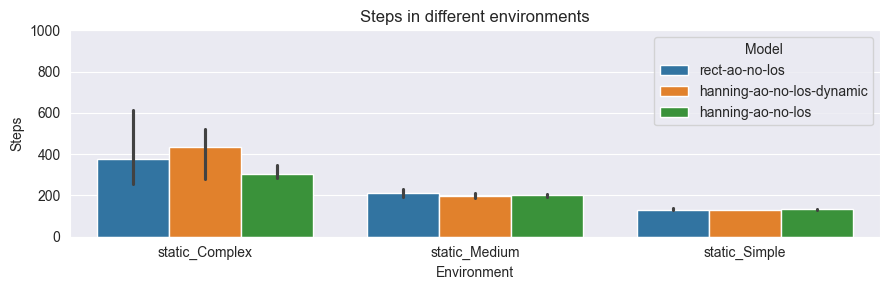

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
from parse_name import parse_filename

base_path = r"../logs"
files = glob.glob(f"{base_path}/*.csv")
MAX_STEPS = 1000
spl_totals = []

for file in files:
    metadata = parse_filename(file)

    df = pd.read_csv(file, sep=";", decimal=",")
    string_cols = ["ClipName"]
    for col in df.columns:
        if col not in string_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    shortest_path = df.groupby("Episode")["PathLength"].first()
    df["FullPath"] = shortest_path

    cols = ["AgentPositionY", "AgentPositionX", "AgentPositionZ"]
    diffs_per_episode = df.groupby(['Episode'], as_index=True)[cols].diff().fillna(0)
    df["DeltaDistance"] = np.sqrt((diffs_per_episode ** 2).sum(axis=1))
    df["Steps"] = df.groupby("Episode")["DeltaDistance"].transform("count")

    travelled = df.groupby("Episode")["DeltaDistance"].sum()
    threshold = 10
    travelled_with_threshold = travelled + threshold

    steps_per_episode = df.groupby("Episode")["Steps"].first()
    success = steps_per_episode <= MAX_STEPS

    spl = success.astype(int) * (shortest_path / pd.DataFrame({'a': shortest_path, 'b': travelled_with_threshold}).max(axis=1))
    spl_total = spl.sum() / len(spl)

    model = metadata.model
    # model = metadata.model + "_" + str(metadata.decision_period)
    environment = metadata.scene + "_" + str(metadata.decision_period)  # In this evaluation, we want to see the effect of decision period
    environment = metadata.scene
    spl_totals.append({"Environment": environment, "Model": model, "SPL": spl_total, "Steps": steps_per_episode.mean()})

# Convert the list of dictionaries to a DataFrame
sorted_spl_totals = pd.DataFrame(spl_totals)

# Sort the DataFrame by SPL values
sorted_spl_totals = sorted_spl_totals.sort_values(by='Steps', ascending=False)

# plt.figure()
plt.figure(figsize=(9, 3))  # Adjust the size of the figure (width, height)
plt.ylim(0, 1000)
sns.barplot(x="Environment", y="Steps", hue="Model", data=sorted_spl_totals)
plt.title("Steps in different environments")
plt.xlabel("Environment")
plt.ylabel("Steps")
plt.tight_layout()
plt.savefig("steps.png")
plt.show()